In [1]:
%matplotlib inline


# LDA Model

Introduces Gensim's LDA model and demonstrates its use on the NIPS corpus.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[Explanation:Logging]('https://docs.python.org/3/howto/logging.html')

The purpose of this tutorial is to demonstrate how to train and tune an LDA model.

In this tutorial we will:

* Load input data.
* Pre-process that data.
* Transform documents into bag-of-words vectors.
* Train an LDA model.

This tutorial will **not**:

* Explain how Latent Dirichlet Allocation works
* Explain how the LDA model performs inference
* Teach you all the parameters and options for Gensim's LDA implementation

If you are not familiar with the LDA model or how to use it in Gensim, I (Olavur Mortensen)
suggest you read up on that before continuing with this tutorial. Basic
understanding of the LDA model should suffice. Examples:

* `Introduction to Latent Dirichlet Allocation <http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation>`_
* Gensim tutorial: `sphx_glr_auto_examples_core_run_topics_and_transformations.py`
* Gensim's LDA model API docs: :py:class:`gensim.models.LdaModel`

I would also encourage you to consider each step when applying the model to
your data, instead of just blindly applying my solution. The different steps
will depend on your data and possibly your goal with the model.

## Data

I have used a corpus of NIPS papers in this tutorial, but if you're following
this tutorial just to learn about LDA I encourage you to consider picking a
corpus on a subject that you are familiar with. Qualitatively evaluating the
output of an LDA model is challenging and can require you to understand the
subject matter of your corpus (depending on your goal with the model).

NIPS (Neural Information Processing Systems) is a machine learning conference
so the subject matter should be well suited for most of the target audience
of this tutorial.  You can download the original data from Sam Roweis'
`website <http://www.cs.nyu.edu/~roweis/data.html>`_.  The code below will
also do that for you.

.. Important::
    The corpus contains 1740 documents, and not particularly long ones.
    So keep in mind that this tutorial is not geared towards efficiency, and be
    careful before applying the code to a large dataset.




In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
# import io
# import os.path
# import re
# import tarfile

# import smart_open

# def extract_documents(url='https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'):
#     with smart_open.open(url, "rb") as file:
#         with tarfile.open(fileobj=file) as tar:
#             for member in tar.getmembers():
#                 if member.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', member.name):
#                     member_bytes = tar.extractfile(member).read()
#                     yield member_bytes.decode('utf-8', errors='replace')

# docs = list(extract_documents())

In [5]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
docs=pd.read_csv("News_Data_TM.csv",index_col="Unnamed: 0").reset_index(drop=True)

In [6]:
docs

,News Headings
0,Quad message to China: ‘Undaunted by coercion’
1,"Democracy to diversity, terror fight to vaccin..."
2,"In Mainpuri school, first lesson for Scheduled..."
3,Bishan Singh Bedi’s 75th birthday is gift for ...
4,"Sunday Long Reads: Of smaller towns, Mughal an..."
...,...
1181,9-member Congress panel to plan ‘sustained agi...
1182,Is the Congress cold shouldering Navjot Singh ...
1183,CBI books Affinity Education for alleged irreg...
1184,Jaishankar discusses key challenges facing Ind...


In [7]:
import numpy as np
docs=np.array(docs["News Headings"])

So we have a list of 1740 documents, where each document is a Unicode string.
If you're thinking about using your own corpus, then you need to make sure
that it's in the same format (list of Unicode strings) before proceeding
with the rest of this tutorial.




In [8]:
print(len(docs))
print(docs)

1186
['Quad message to China: ‘Undaunted by coercion’'
 'Democracy to diversity, terror fight to vaccine — when India grows, so...'
 'In Mainpuri school, first lesson for Scheduled Caste students: Keep your plates...'
 ...
 'CBI books Affinity Education for alleged irregularities in JEE (Mains) examination'
 'Jaishankar discusses key challenges facing India and EU with Slovenian president'
 'Afghan-origin terror prime concern: India']


In [9]:
import string
def punctuation_removal(text):
    #Punctuation
    import string # special operations on string
    no_punc_text = text.translate(str.maketrans('', '', string.punctuation))
    # with arg (x, y, z) where x $ y must be equal-length strings. char x replace by char y. and z is string
    return no_punc_text
    

In [10]:
!pip install nltk

In [11]:
#stopwards
from nltk.corpus import stopwords
import nltk

# nltk.download('punkt')
# nltk.download('stopwords')

In [12]:
from nltk.tokenize import word_tokenize #sent_tokenize
def tokenization(no_punc_text):
    #Tokenization
    text_token = word_tokenize(no_punc_text)
    return text_token

In [13]:
def stopword_removal(text_token):
    # Remove stopwords

    my_stop_words = stopwords.words('english')
    new_stop_word=['Says','says','plea','say','take','‘','In','’','—','Of','We', 'got','Two','And','I', 'The','No','Will','new','u','U']
    my_stop_words.extend(new_stop_word)

    no_stop_tokens = [w for w in text_token if not w in my_stop_words]
    return no_stop_tokens

In [14]:
docs1=[]
for i,doc1 in enumerate(docs):
    doc1=doc1.lower()
    no_punc_text=punctuation_removal(doc1)
    text_token=tokenization(no_punc_text)
    no_stop_tokens=stopword_removal(text_token)
    #print(no_stop_tokens)
    docs1.append(no_stop_tokens)
# Remove numbers, but not words that contain numbers.
docs1 = [[token for token in doc if not token.isnumeric()] for doc in docs1]

# Remove words that are only one character.
docs1 = [[token for token in doc if len(token) > 1] for doc in docs1]
docs1

[['quad', 'message', 'china', 'undaunted', 'coercion'],
 ['democracy', 'diversity', 'terror', 'fight', 'vaccine', 'india', 'grows'],
 ['mainpuri',
  'school',
  'first',
  'lesson',
  'scheduled',
  'caste',
  'students',
  'keep',
  'plates'],
 ['bishan', 'singh', 'bedi', '75th', 'birthday', 'gift', 'family', 'friends'],
 ['sunday',
  'long',
  'reads',
  'smaller',
  'towns',
  'mughal',
  'rajput',
  'paintings',
  'book',
  'reviews'],
 ['two',
  'children',
  'books',
  'aai',
  'world',
  'awaits',
  'explore',
  'identity',
  'acts',
  'kindness'],
 ['ipl', 'holding', 'sunrisers', 'despite', 'paltry', 'target', 'kings'],
 ['eight', 'films', 'shows', 'country', 'side'],
 ['punjab',
  'cabinet',
  'considered',
  'rahul',
  'gandhi',
  'man',
  'nagra',
  'party',
  'post',
  'cabinet',
  'spot'],
 ['quit',
  'party',
  'mlas',
  'risk',
  'msp',
  'quota',
  'private',
  'jobs',
  'oct',
  'dushyant',
  'chautala'],
 ['shiromani', 'akali', 'dal', 'hits', 'warring', 'kotli'],
 ['r

In [15]:
docs1

[['quad', 'message', 'china', 'undaunted', 'coercion'],
 ['democracy', 'diversity', 'terror', 'fight', 'vaccine', 'india', 'grows'],
 ['mainpuri',
  'school',
  'first',
  'lesson',
  'scheduled',
  'caste',
  'students',
  'keep',
  'plates'],
 ['bishan', 'singh', 'bedi', '75th', 'birthday', 'gift', 'family', 'friends'],
 ['sunday',
  'long',
  'reads',
  'smaller',
  'towns',
  'mughal',
  'rajput',
  'paintings',
  'book',
  'reviews'],
 ['two',
  'children',
  'books',
  'aai',
  'world',
  'awaits',
  'explore',
  'identity',
  'acts',
  'kindness'],
 ['ipl', 'holding', 'sunrisers', 'despite', 'paltry', 'target', 'kings'],
 ['eight', 'films', 'shows', 'country', 'side'],
 ['punjab',
  'cabinet',
  'considered',
  'rahul',
  'gandhi',
  'man',
  'nagra',
  'party',
  'post',
  'cabinet',
  'spot'],
 ['quit',
  'party',
  'mlas',
  'risk',
  'msp',
  'quota',
  'private',
  'jobs',
  'oct',
  'dushyant',
  'chautala'],
 ['shiromani', 'akali', 'dal', 'hits', 'warring', 'kotli'],
 ['r

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a
stemmer in this case because it produces more readable words. Output that is
easy to read is very desirable in topic modelling.




In [16]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs1]


In [17]:
docs

[['quad', 'message', 'china', 'undaunted', 'coercion'],
 ['democracy', 'diversity', 'terror', 'fight', 'vaccine', 'india', 'grows'],
 ['mainpuri',
  'school',
  'first',
  'lesson',
  'scheduled',
  'caste',
  'student',
  'keep',
  'plate'],
 ['bishan', 'singh', 'bedi', '75th', 'birthday', 'gift', 'family', 'friend'],
 ['sunday',
  'long',
  'read',
  'smaller',
  'town',
  'mughal',
  'rajput',
  'painting',
  'book',
  'review'],
 ['two',
  'child',
  'book',
  'aai',
  'world',
  'awaits',
  'explore',
  'identity',
  'act',
  'kindness'],
 ['ipl', 'holding', 'sunrisers', 'despite', 'paltry', 'target', 'king'],
 ['eight', 'film', 'show', 'country', 'side'],
 ['punjab',
  'cabinet',
  'considered',
  'rahul',
  'gandhi',
  'man',
  'nagra',
  'party',
  'post',
  'cabinet',
  'spot'],
 ['quit',
  'party',
  'mlas',
  'risk',
  'msp',
  'quota',
  'private',
  'job',
  'oct',
  'dushyant',
  'chautala'],
 ['shiromani', 'akali', 'dal', 'hit', 'warring', 'kotli'],
 ['ram', 'belongs', '

We find bigrams in the documents. Bigrams are sets of two adjacent words.
Using bigrams we can get phrases like "machine_learning" in our output
(spaces are replaced with underscores); without bigrams we would only get
"machine" and "learning".

Note that in the code below, we find bigrams and then add them to the
original data, because we would like to keep the words "machine" and
"learning" as well as the bigram "machine_learning".

.. Important::
    Computing n-grams of large dataset can be very computationally
    and memory intensive.




In [18]:
# To creat single list of tokens
tokens1=[item for sublist in docs for item in sublist]

In [19]:
clean_text = ' '.join(tokens1)
clean_text

'quad message china undaunted coercion democracy diversity terror fight vaccine india grows mainpuri school first lesson scheduled caste student keep plate bishan singh bedi 75th birthday gift family friend sunday long read smaller town mughal rajput painting book review two child book aai world awaits explore identity act kindness ipl holding sunrisers despite paltry target king eight film show country side punjab cabinet considered rahul gandhi man nagra party post cabinet spot quit party mlas risk msp quota private job oct dushyant chautala shiromani akali dal hit warring kotli ram belongs entire world bjp r farooq abdullah gupta leave spl dgp sahota get addl charge punjab police chief kin slain worker tow bjp slam tmc reign terror time speak liberalism cong bjp betrayed country cm mamata banerjee future afghanistan smriti irani mamata banerjee contesting interest trinamool hit back pandals set friendly senior citizen differentlyabled mischievous fake crusade vaccination drive stude

In [20]:
from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [21]:
# Image packege
from wordcloud import WordCloud, STOPWORDS
# define  a function to plot wordcloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30)) # set figure size
    plt.imshow(wordcloud)       #Display image
    plt.axis('off')             #NO axis detials

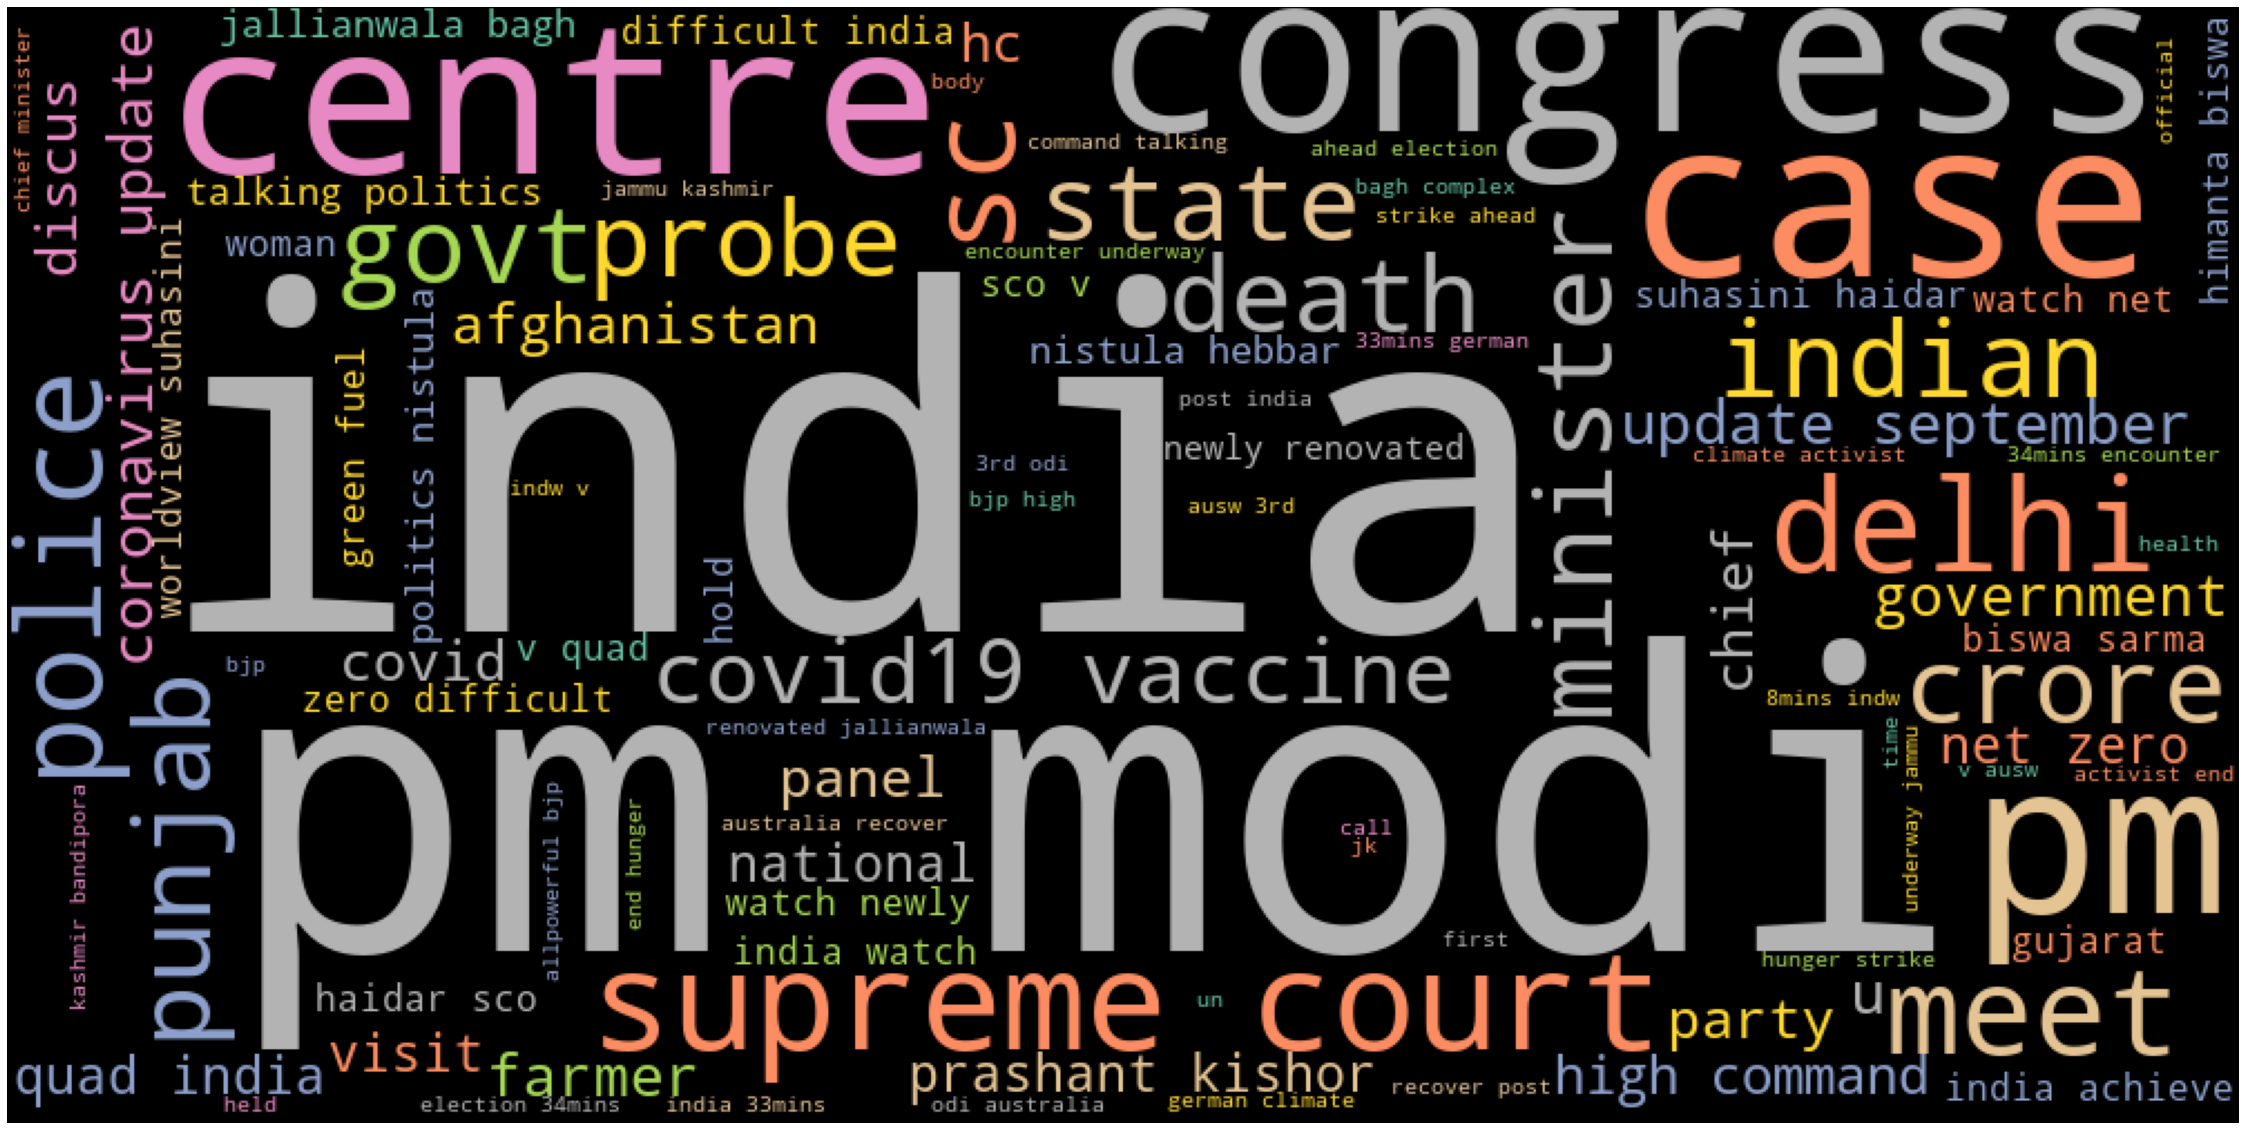

In [22]:
# Generate wordcloud
wordcloud=WordCloud(width=1000,height=500,background_color='black',max_words=100,colormap='Set2',stopwords=None).generate(clean_text)
#plot
plot_cloud(wordcloud)

In [23]:
bigrams_series = (pd.Series(nltk.ngrams(tokens1, 2)).value_counts())[0:10]
bigrams_series

(pm, modi)               49
(supreme, court)         35
(coronavirus, update)    19
(update, september)      19
(covid19, vaccine)       19
(high, command)          16
(jallianwala, bagh)      15
(talking, politics)      15
(nistula, hebbar)        15
(quad, india)            15
dtype: int64

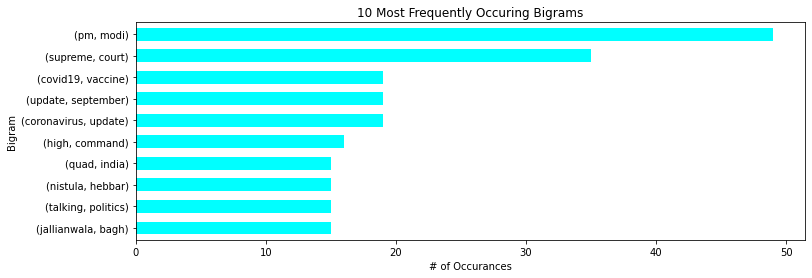

In [24]:
bigrams_series.sort_values().plot.barh(color='cyan', width=.6, figsize=(12, 4))
plt.title('10 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')
plt.show()

In [25]:
trigrams_series = (pd.Series(nltk.ngrams(tokens1, 3)).value_counts())[0:10]
len(trigrams_series)

10

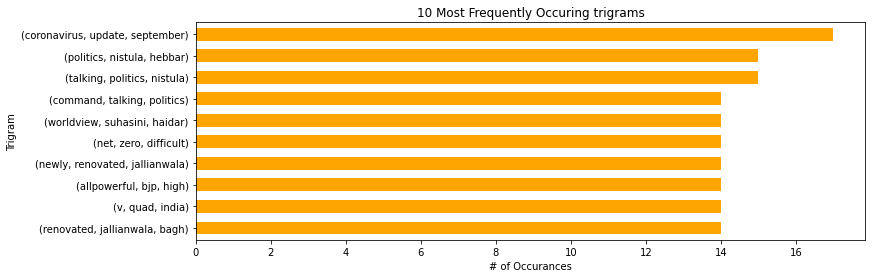

In [26]:
trigrams_series.sort_values().plot.barh(color='orange', width=.6, figsize=(12, 4))
plt.title('10 Most Frequently Occuring trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')
plt.show()

We remove rare words and common words based on their *document frequency*.
Below we remove words that appear in less than 20 documents or in more than
50% of the documents. Consider trying to remove words only based on their
frequency, or maybe combining that with this approach.




In [27]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

2021-09-28 02:57:36,416 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-28 02:57:36,456 : INFO : built Dictionary(2961 unique tokens: ['china', 'coercion', 'message', 'quad', 'undaunted']...) from 1186 documents (total 9264 corpus positions)
2021-09-28 02:57:36,458 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(2961 unique tokens: ['china', 'coercion', 'message', 'quad', 'undaunted']...) from 1186 documents (total 9264 corpus positions)", 'datetime': '2021-09-28T02:57:36.457598', 'gensim': '4.0.1', 'python': '3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-09-28 02:57:36,469 : INFO : discarding 2536 tokens: [('coercion', 1), ('undaunted', 1), ('diversity', 1), ('fight', 2), ('grows', 2), ('keep', 3), ('lesson', 1), ('mainpuri', 2), ('plate', 1), ('scheduled', 1)]...
2021-09-28 02:57:36,470 : INFO : keeping 425 tokens which were in no less than 5 and no more than 

In [28]:
len(dict(dictionary))

425

In [29]:
dict(dictionary)

{0: 'china',
 1: 'message',
 2: 'quad',
 3: 'democracy',
 4: 'india',
 5: 'terror',
 6: 'vaccine',
 7: 'caste',
 8: 'first',
 9: 'school',
 10: 'student',
 11: 'birthday',
 12: 'family',
 13: 'gift',
 14: 'singh',
 15: 'book',
 16: 'review',
 17: 'child',
 18: 'two',
 19: 'world',
 20: 'country',
 21: 'show',
 22: 'cabinet',
 23: 'gandhi',
 24: 'man',
 25: 'party',
 26: 'post',
 27: 'punjab',
 28: 'rahul',
 29: 'oct',
 30: 'quota',
 31: 'hit',
 32: 'bjp',
 33: 'r',
 34: 'ram',
 35: 'charge',
 36: 'chief',
 37: 'get',
 38: 'police',
 39: 'tmc',
 40: 'worker',
 41: 'time',
 42: 'banerjee',
 43: 'cm',
 44: 'mamata',
 45: 'afghanistan',
 46: 'trinamool',
 47: 'set',
 48: 'ahead',
 49: 'bengal',
 50: 'drive',
 51: 'govt',
 52: 'vaccination',
 53: 'west',
 54: 'congress',
 55: 'held',
 56: 'month',
 57: 'case',
 58: 'temple',
 59: 'call',
 60: 'firm',
 61: 'centre',
 62: 'state',
 63: 'u',
 64: 'vote',
 65: 'channi',
 66: 'due',
 67: 'across',
 68: 'want',
 69: 'ev',
 70: 'bank',
 71: 'recor

Finally, we transform the documents to a vectorized form. We simply compute
the frequency of each word, including the bigrams.




In [30]:
len(docs)

1186

In [31]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [32]:
corpus[2:5]

[[(7, 1), (8, 1), (9, 1), (10, 1)],
 [(11, 1), (12, 1), (13, 1), (14, 1)],
 [(15, 1), (16, 1)]]

Let's see how many tokens and documents we have to train on.




In [33]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 425
Number of documents: 1186


## Training

We are ready to train the LDA model. We will first discuss how to set some of
the training parameters.

First of all, the elephant in the room: how many topics do I need? There is
really no easy answer for this, it will depend on both your data and your
application. I have used 10 topics here because I wanted to have a few topics
that I could interpret and "label", and because that turned out to give me
reasonably good results. You might not need to interpret all your topics, so
you could use a large number of topics, for example 100.

``chunksize`` controls how many documents are processed at a time in the
training algorithm. Increasing chunksize will speed up training, at least as
long as the chunk of documents easily fit into memory. I've set ``chunksize =
2000``, which is more than the amount of documents, so I process all the
data in one go. Chunksize can however influence the quality of the model, as
discussed in Hoffman and co-authors [2], but the difference was not
substantial in this case.

``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.

I suggest the following way to choose iterations and passes. First, enable
logging (as described in many Gensim tutorials), and set ``eval_every = 1``
in ``LdaModel``. When training the model look for a line in the log that
looks something like this::

   2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations

If you set ``passes = 20`` you will see this line 20 times. Make sure that by
the final passes, most of the documents have converged. So you want to choose
both passes and iterations to be high enough for this to happen.

We set ``alpha = 'auto'`` and ``eta = 'auto'``. Again this is somewhat
technical, but essentially we are automatically learning two parameters in
the model that we usually would have to specify explicitly.




In [34]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 1200
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
#temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2021-09-28 02:57:37,290 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2021-09-28 02:57:37,291 : INFO : using serial LDA version on this node
2021-09-28 02:57:37,295 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 1186 documents, updating model once every 1186 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-09-28 02:57:37,299 : INFO : PROGRESS: pass 0, at document #1186/1186
2021-09-28 02:57:37,959 : INFO : optimized alpha [0.08978516, 0.09032154, 0.0874894, 0.08742105, 0.08993331, 0.09264752, 0.08864109, 0.09139341, 0.088100806, 0.0866993]
2021-09-28 02:57:37,964 : INFO : topic #9 (0.087): 0.033*"vaccine" + 0.025*"1hr" + 0.023*"use" + 0.018*"pm" + 0.018*"manufacturer" + 0.018*"mrna" + 0.018*"share" + 0.018*"knowhow" + 0.018*"loath" + 0.017*"india"
2021-09-28 02:57:37,967 : INFO : topic #3 (0.087): 0.024*"pm" + 0.024*"far

2021-09-28 02:57:39,890 : INFO : topic #1 (0.081): 0.075*"pm" + 0.065*"modi" + 0.035*"india" + 0.027*"un" + 0.024*"goa" + 0.020*"popular" + 0.020*"history" + 0.020*"museum" + 0.019*"brewing" + 0.019*"provides"
2021-09-28 02:57:39,891 : INFO : topic #5 (0.085): 0.054*"u" + 0.045*"india" + 0.043*"case" + 0.035*"2hrs" + 0.033*"september" + 0.033*"update" + 0.030*"coronavirus" + 0.025*"taliban" + 0.025*"pm" + 0.023*"pakistan"
2021-09-28 02:57:39,893 : INFO : topic diff=0.313518, rho=0.377964
2021-09-28 02:57:39,897 : INFO : PROGRESS: pass 6, at document #1186/1186
2021-09-28 02:57:40,235 : INFO : optimized alpha [0.06861071, 0.07980587, 0.07345163, 0.07881218, 0.07886602, 0.084233746, 0.07453845, 0.07222774, 0.075313956, 0.073805846]
2021-09-28 02:57:40,239 : INFO : topic #0 (0.069): 0.041*"tax" + 0.040*"ahead" + 0.037*"election" + 0.034*"district" + 0.032*"climate" + 0.032*"end" + 0.032*"operation" + 0.028*"strike" + 0.028*"activist" + 0.028*"relief"
2021-09-28 02:57:40,240 : INFO : topic

2021-09-28 02:57:41,869 : INFO : topic #3 (0.078): 0.039*"delhi" + 0.038*"police" + 0.030*"case" + 0.028*"probe" + 0.027*"farmer" + 0.025*"cbi" + 0.022*"crore" + 0.021*"centre" + 0.020*"charge" + 0.018*"official"
2021-09-28 02:57:41,870 : INFO : topic #5 (0.080): 0.059*"u" + 0.047*"india" + 0.040*"september" + 0.039*"2hrs" + 0.035*"update" + 0.033*"coronavirus" + 0.029*"case" + 0.027*"pm" + 0.026*"taliban" + 0.026*"foreign"
2021-09-28 02:57:41,873 : INFO : topic diff=0.114727, rho=0.277350
2021-09-28 02:57:41,878 : INFO : PROGRESS: pass 12, at document #1186/1186
2021-09-28 02:57:42,188 : INFO : optimized alpha [0.060070034, 0.075987026, 0.0703078, 0.078247555, 0.07644357, 0.07923796, 0.06726795, 0.063522816, 0.07271994, 0.06897941]
2021-09-28 02:57:42,190 : INFO : topic #0 (0.060): 0.044*"tax" + 0.043*"ahead" + 0.040*"election" + 0.037*"district" + 0.033*"climate" + 0.033*"end" + 0.033*"operation" + 0.029*"strike" + 0.029*"activist" + 0.029*"relief"
2021-09-28 02:57:42,193 : INFO : to

2021-09-28 02:57:43,682 : INFO : topic #4 (0.076): 0.054*"chief" + 0.052*"minister" + 0.036*"kashmir" + 0.027*"bjp" + 0.022*"bandipora" + 0.022*"encounter" + 0.022*"jammu" + 0.022*"underway" + 0.022*"34mins" + 0.020*"cm"
2021-09-28 02:57:43,686 : INFO : topic #5 (0.076): 0.061*"u" + 0.048*"india" + 0.042*"september" + 0.040*"2hrs" + 0.036*"update" + 0.035*"coronavirus" + 0.027*"pm" + 0.027*"taliban" + 0.027*"foreign" + 0.025*"pakistan"
2021-09-28 02:57:43,690 : INFO : topic #3 (0.078): 0.043*"case" + 0.042*"delhi" + 0.040*"police" + 0.030*"probe" + 0.026*"farmer" + 0.025*"cbi" + 0.023*"crore" + 0.022*"centre" + 0.020*"charge" + 0.018*"official"
2021-09-28 02:57:43,693 : INFO : topic diff=0.044092, rho=0.229416
2021-09-28 02:57:43,698 : INFO : PROGRESS: pass 18, at document #1186/1186
2021-09-28 02:57:43,986 : INFO : optimized alpha [0.054953594, 0.07358745, 0.06898373, 0.078368835, 0.075412296, 0.07553249, 0.06257168, 0.058044344, 0.071569465, 0.06635825]
2021-09-28 02:57:43,989 : INFO

In [35]:
print(id2word)

{0: 'china', 1: 'message', 2: 'quad', 3: 'democracy', 4: 'india', 5: 'terror', 6: 'vaccine', 7: 'caste', 8: 'first', 9: 'school', 10: 'student', 11: 'birthday', 12: 'family', 13: 'gift', 14: 'singh', 15: 'book', 16: 'review', 17: 'child', 18: 'two', 19: 'world', 20: 'country', 21: 'show', 22: 'cabinet', 23: 'gandhi', 24: 'man', 25: 'party', 26: 'post', 27: 'punjab', 28: 'rahul', 29: 'oct', 30: 'quota', 31: 'hit', 32: 'bjp', 33: 'r', 34: 'ram', 35: 'charge', 36: 'chief', 37: 'get', 38: 'police', 39: 'tmc', 40: 'worker', 41: 'time', 42: 'banerjee', 43: 'cm', 44: 'mamata', 45: 'afghanistan', 46: 'trinamool', 47: 'set', 48: 'ahead', 49: 'bengal', 50: 'drive', 51: 'govt', 52: 'vaccination', 53: 'west', 54: 'congress', 55: 'held', 56: 'month', 57: 'case', 58: 'temple', 59: 'call', 60: 'firm', 61: 'centre', 62: 'state', 63: 'u', 64: 'vote', 65: 'channi', 66: 'due', 67: 'across', 68: 'want', 69: 'ev', 70: 'bank', 71: 'record', 72: 'report', 73: 'tell', 74: 'name', 75: 'odisha', 76: 'arrested',

We can compute the topic coherence of each topic. Below we display the
average topic coherence and print the topics in order of topic coherence.

Note that we use the "Umass" topic coherence measure here (see
:py:func:`gensim.models.ldamodel.LdaModel.top_topics`), Gensim has recently
obtained an implementation of the "AKSW" topic coherence measure (see
accompanying blog post, http://rare-technologies.com/what-is-topic-coherence/).

If you are familiar with the subject of the articles in this dataset, you can
see that the topics below make a lot of sense. However, they are not without
flaws. We can see that there is substantial overlap between some topics,
others are hard to interpret, and most of them have at least some terms that
seem out of place. If you were able to do better, feel free to share your
methods on the blog at http://rare-technologies.com/lda-training-tips/ !




In [36]:
# top_topics = model.top_topics(corpus) #, num_words=20)

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# from pprint import pprint
# pprint(top_topics)

In [37]:
from pprint import pprint

In [38]:
# Print the Keyword in the 10 topics
pprint(model.print_topics())
doc_lda = model[corpus]

2021-09-28 02:57:44,703 : INFO : topic #0 (0.054): 0.044*"tax" + 0.044*"ahead" + 0.040*"election" + 0.038*"district" + 0.034*"climate" + 0.034*"end" + 0.034*"operation" + 0.030*"strike" + 0.030*"activist" + 0.030*"relief"
2021-09-28 02:57:44,707 : INFO : topic #1 (0.073): 0.093*"pm" + 0.082*"modi" + 0.046*"india" + 0.036*"un" + 0.026*"goa" + 0.021*"history" + 0.021*"popular" + 0.021*"museum" + 0.021*"gujarat" + 0.020*"peek"
2021-09-28 02:57:44,714 : INFO : topic #2 (0.069): 0.059*"congress" + 0.034*"panel" + 0.034*"rahul" + 0.032*"party" + 0.032*"gandhi" + 0.031*"sc" + 0.027*"punjab" + 0.022*"oct" + 0.022*"code" + 0.022*"updated"
2021-09-28 02:57:44,719 : INFO : topic #3 (0.078): 0.045*"case" + 0.043*"delhi" + 0.041*"police" + 0.031*"probe" + 0.026*"farmer" + 0.025*"cbi" + 0.023*"crore" + 0.021*"centre" + 0.020*"charge" + 0.018*"official"
2021-09-28 02:57:44,723 : INFO : topic #4 (0.075): 0.054*"chief" + 0.053*"minister" + 0.036*"kashmir" + 0.027*"bjp" + 0.022*"bandipora" + 0.022*"enco

[(0,
  '0.044*"tax" + 0.044*"ahead" + 0.040*"election" + 0.038*"district" + '
  '0.034*"climate" + 0.034*"end" + 0.034*"operation" + 0.030*"strike" + '
  '0.030*"activist" + 0.030*"relief"'),
 (1,
  '0.093*"pm" + 0.082*"modi" + 0.046*"india" + 0.036*"un" + 0.026*"goa" + '
  '0.021*"history" + 0.021*"popular" + 0.021*"museum" + 0.021*"gujarat" + '
  '0.020*"peek"'),
 (2,
  '0.059*"congress" + 0.034*"panel" + 0.034*"rahul" + 0.032*"party" + '
  '0.032*"gandhi" + 0.031*"sc" + 0.027*"punjab" + 0.022*"oct" + 0.022*"code" + '
  '0.022*"updated"'),
 (3,
  '0.045*"case" + 0.043*"delhi" + 0.041*"police" + 0.031*"probe" + '
  '0.026*"farmer" + 0.025*"cbi" + 0.023*"crore" + 0.021*"centre" + '
  '0.020*"charge" + 0.018*"official"'),
 (4,
  '0.054*"chief" + 0.053*"minister" + 0.036*"kashmir" + 0.027*"bjp" + '
  '0.022*"bandipora" + 0.022*"encounter" + 0.022*"jammu" + 0.022*"underway" + '
  '0.022*"34mins" + 0.020*"cm"'),
 (5,
  '0.062*"u" + 0.049*"india" + 0.042*"september" + 0.041*"2hrs" + '
  '0.

### Visualisation

In [39]:
from itertools import chain
import pyLDAvis
import pyLDAvis.gensim_models #LDA visualization library

In [40]:
lda_display = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

C:\Users\1234\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-09-28 02:57:45,847 : INFO : NumExpr defaulting to 4 threads.


### Compute model perplexity and coherence score

In [50]:
from gensim.models.coherencemodel import CoherenceModel
cm = cm = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary,texts=docs,coherence='c_v')
coherence = cm.get_coherence()  # get coherence value

C:\Users\1234\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-09-28 03:09:49,086 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2021-09-28 03:09:54,624 : INFO : 3 accumulators retrieved from output queue
2021-09-28 03:09:54,667 : INFO : accumulated word occurrence stats for 1038 virtual documents


In [55]:
print('\nPerplexity: ', model.log_perplexity(corpus,total_docs=1740))  # a measure of how good the model is. lower the better.

print('Coherence Score:',coherence)

C:\Users\1234\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-09-28 03:11:39,606 : INFO : -5.440 per-word bound, 43.4 perplexity estimate based on a held-out corpus of 1186 documents with 5510 words



Perplexity:  -5.439841815197458
Coherence Score: 0.3775390081943079


## Things to experiment with

* ``no_above`` and ``no_below`` parameters in ``filter_extremes`` method.
* Adding trigrams or even higher order n-grams.
* Consider whether using a hold-out set or cross-validation is the way to go for you.
* Try other datasets.

## Where to go from here

* Check out a RaRe blog post on the AKSW topic coherence measure (http://rare-technologies.com/what-is-topic-coherence/).
* pyLDAvis (https://pyldavis.readthedocs.io/en/latest/index.html).
* Read some more Gensim tutorials (https://github.com/RaRe-Technologies/gensim/blob/develop/tutorials.md#tutorials).
* If you haven't already, read [1] and [2] (see references).

## References

1. "Latent Dirichlet Allocation", Blei et al. 2003.
2. "Online Learning for Latent Dirichlet Allocation", Hoffman et al. 2010.


